In [15]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np


In [18]:
file_path = '../RiceDatathon/OilData.csv'
data = pd.read_csv(file_path)

data.head()


,Unnamed: 0,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,...,relative_well_position,batch_frac_classification,well_family_relationship,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,NaN,76000.0000,NaN,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383030.678,714796.3610,1382668.912,712798.4321,46.623023
1,1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,NaN,113000.0000,5.610964e+05,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379965.126,709541.7145,1379630.025,707907.6708,59.750009
2,2,1379915.895,717845.0063,1379274.644,713471.9952,1304,3810.039370,12.0,286571.4286,1.621424e+06,...,Standalone Well,Non-Batch Frac,Standalone Well,Primary Frac,92.0,1379357.250,715381.2327,1378960.372,713530.4490,10.785716
3,3,1383567.443,706640.2010,1382891.477,702068.3838,1022,3723.425197,11.0,106878.9286,4.377134e+05,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383099.610,704058.8508,1382727.299,702098.4882,123.797638
4,4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,NaN,112789.7143,6.229802e+05,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379546.414,705150.7519,1379987.487,707123.7258,102.309540


In [27]:
# Dropping the unnecessary 'Unnamed: 0' column
data_cleaned = data.drop(columns=['Unnamed: 0'])

# Handling missing values
# Dropping columns with more than 50% missing values
threshold = 50  # percentage
missing_values_percentage = (data_cleaned.isnull().sum() / len(data_cleaned)) * 100
columns_to_drop = missing_values_percentage[missing_values_percentage > threshold].index
data_reduced = data_cleaned.drop(columns=columns_to_drop)

# For columns with moderate missing values, we will impute missing values
# Using median for numerical columns and mode for categorical columns
for column in data_reduced.columns:
    if data_reduced[column].isnull().sum() > 0:
        if data_reduced[column].dtype == 'object':
            # Categorical column - use mode
            mode_value = data_reduced[column].mode()[0]
            data_reduced[column].fillna(mode_value, inplace=True)
        else:
            # Numerical column - use median
            median_value = data_reduced[column].median()
            data_reduced[column].fillna(median_value, inplace=True)

# Check if there are any missing values left
remaining_missing = data_reduced.isnull().sum().sum()

# Overview of the cleaned dataset
data_reduced.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29692 entries, 0 to 29691
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   surface_x                     29692 non-null  float64
 1   surface_y                     29692 non-null  float64
 2   bh_x                          29692 non-null  float64
 3   bh_y                          29692 non-null  float64
 4   standardized_operator_name    29692 non-null  int64  
 5   gross_perforated_length       29692 non-null  float64
 6   total_proppant                29692 non-null  float64
 7   total_fluid                   29692 non-null  float64
 8   true_vertical_depth           29692 non-null  float64
 9   proppant_intensity            29692 non-null  float64
 10  frac_fluid_intensity          29692 non-null  float64
 11  proppant_to_frac_fluid_ratio  29692 non-null  float64
 12  frac_fluid_to_proppant_ratio  29692 non-null  float64
 13  b

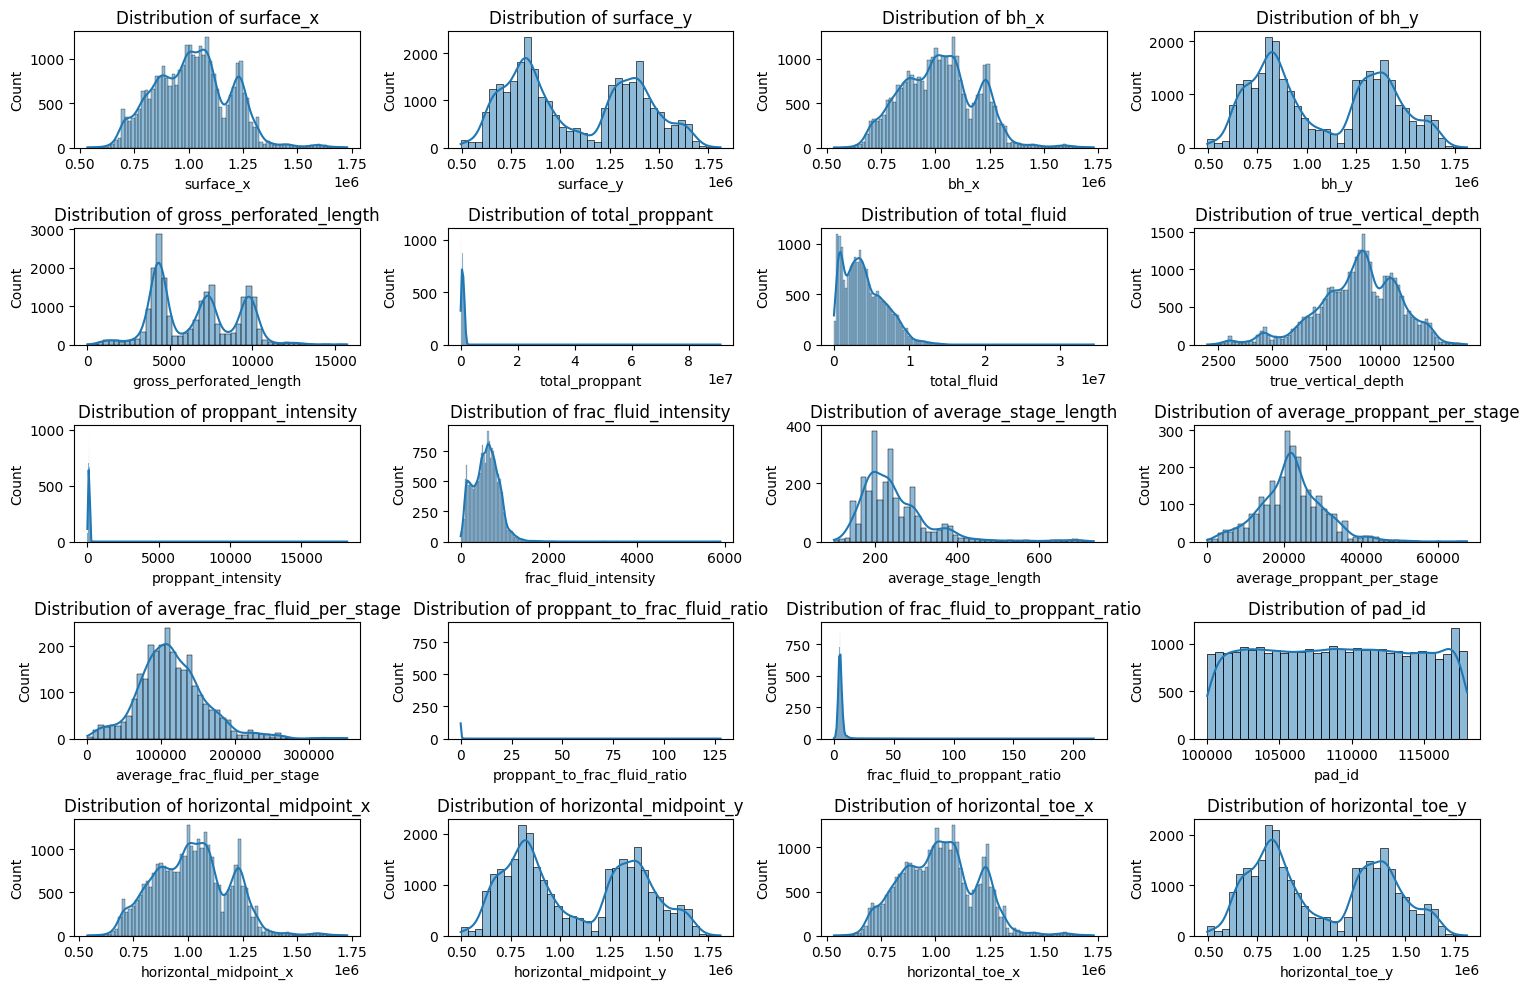

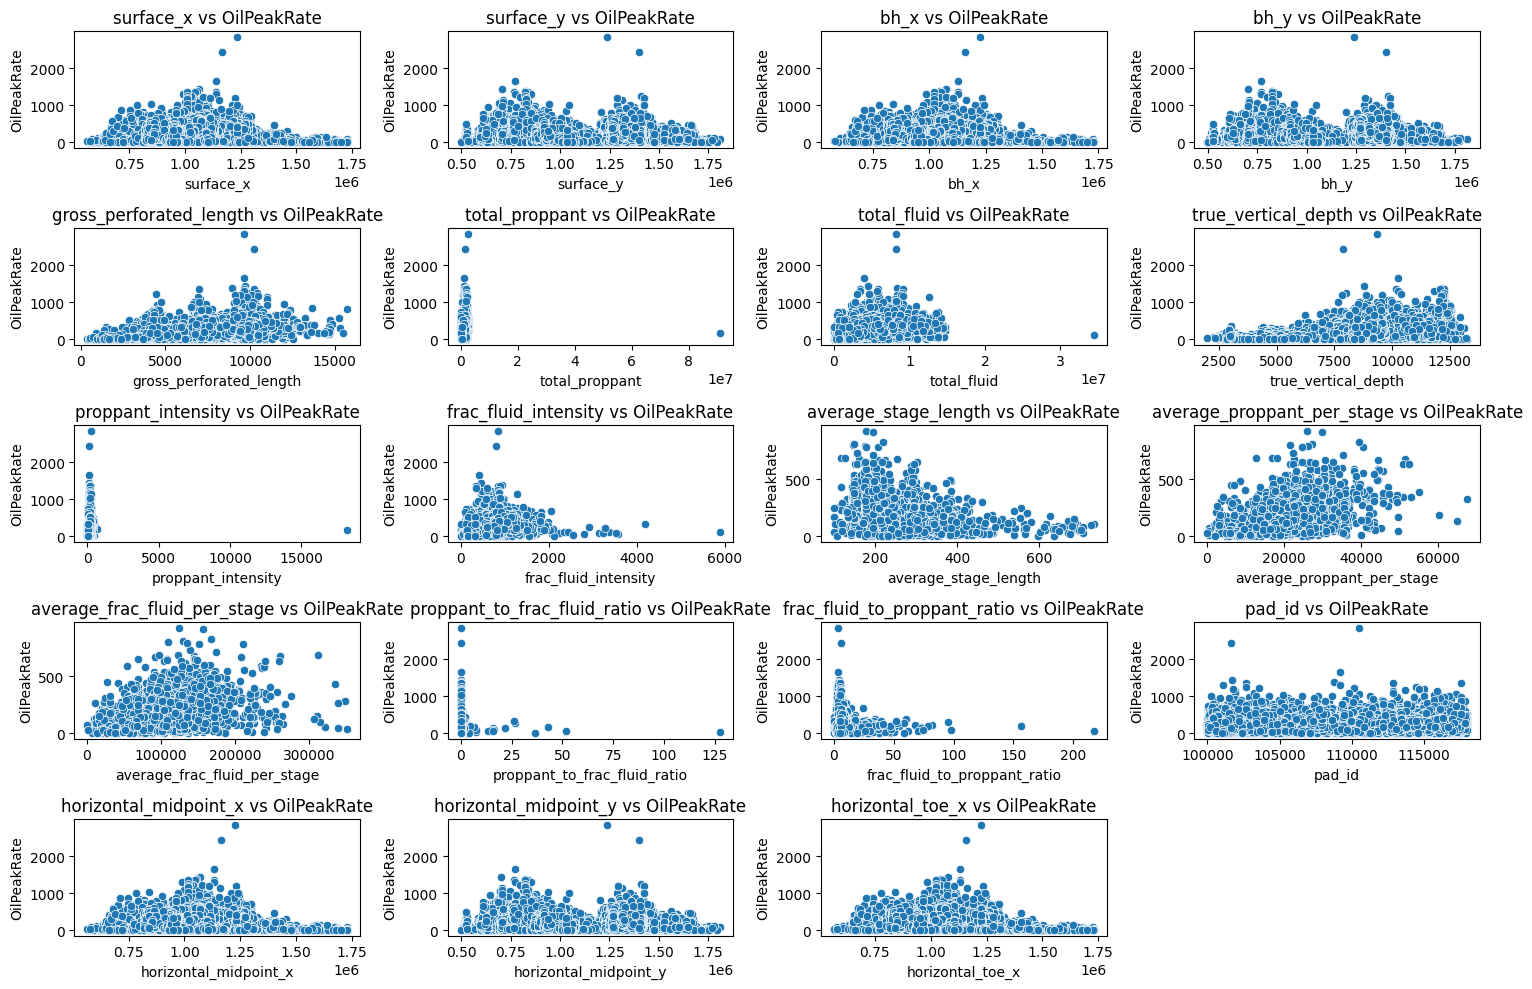

In [29]:
# Histograms for numerical variables
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','average_stage_length',
                     'average_proppant_per_stage','average_frac_fluid_per_stage','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','pad_id','horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y']  # Replace with your numerical columns
# numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data_cleaned[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Scatter plots for relationships with target variable
target_variable = 'OilPeakRate'  # Replace with your target variable
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns[:-1], 1):
    plt.subplot(5, 4, i)
    sns.scatterplot(x=data_cleaned[column], y=data_cleaned[target_variable])
    plt.title(f'{column} vs {target_variable}')
plt.tight_layout()
plt.show()
